<a href="https://colab.research.google.com/github/dscho15/DeepLearning/blob/main/Lecture3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MLP (one hidden layer) for classification on Cifar10

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T

In [32]:
transform = T.Compose([T.ToTensor()])

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
loader_train = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=False, num_workers=2)
loader_valid = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=False, num_workers=2)
loader_test = torch.utils.data.DataLoader(data_test, batch_size=256, shuffle=False, num_workers=2)

# Challenge
* Build a Multi Layer Perceptron, MLP, with one ReLU-activated hidden layer.
* Use the validation set to inform e.g. number of hidden neurons.
* When you're satisfied, then, use the test set to get an  
unbiased estimate of your models performance on the real data distribution.

In [82]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            # Inputs
            nn.Flatten(),
            nn.BatchNorm1d(32*32*3),
            nn.Linear(32*32*3, n_hidden_neurons),
            nn.ReLU(),

            nn.BatchNorm1d(n_hidden_neurons),
            nn.Dropout(0.5),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.ReLU(),

            nn.BatchNorm1d(n_hidden_neurons),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(n_hidden_neurons),

            nn.BatchNorm1d(n_hidden_neurons),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(n_hidden_neurons),

            nn.BatchNorm1d(n_hidden_neurons),
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(n_hidden_neurons),

            # Logits
            nn.Linear(n_hidden_neurons, 10)
        )

    def forward(self, x):
        logits = self.model(x)
        return logits

In [97]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

In [98]:
device = torch.device('cuda')
n_hidden_neurons = 1024
model = NeuralNetwork(n_hidden_neurons).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=2e-6)

train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(50):

    print("Epoch: %s"%(epoch), ' {:f}'.format(best_accuracy))

    model.train()

    epoch_losses = []
    correct, total = 0, 0

    for x, y in loader_train:
        
        x, y = x.to(device), y.to(device)
        
        logits = model(x)
        log_probs = F.log_softmax(logits, dim=1)
        loss = F.nll_loss(log_probs, y)
        # or just: loss = F.cross_entropy(logits, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()

    train_loss = np.mean(epoch_losses)
    train_accuracy = correct / total

    # validation

    with torch.no_grad():

        model.eval()

        valid_losses_batch = []
        correct, total = 0, 0

        for x, y in loader_valid:

            x, y = x.to(device), y.to(device)
            logits = model(x)
            log_probs = F.log_softmax(logits, dim=1)
            loss = F.nll_loss(log_probs, y)

            total += len(x)
            valid_losses_batch.append(loss.item())
            correct += (torch.argmax(logits, dim=1) == y).sum().item()
    
    valid_loss = np.mean(valid_losses_batch)
    valid_accuracy = correct/total

    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        best_model = copy.deepcopy(model), n_hidden_neurons, epoch

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

all_losses[n_hidden_neurons] = train_losses, valid_losses
all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

Epoch: 0  0.000000
Epoch: 1  0.444000
Epoch: 2  0.477400
Epoch: 3  0.508400
Epoch: 4  0.519400
Epoch: 5  0.539200
Epoch: 6  0.544400
Epoch: 7  0.551800
Epoch: 8  0.551800
Epoch: 9  0.565800
Epoch: 10  0.565800
Epoch: 11  0.567800
Epoch: 12  0.569600
Epoch: 13  0.569600
Epoch: 14  0.569600
Epoch: 15  0.574200
Epoch: 16  0.579600
Epoch: 17  0.579600
Epoch: 18  0.583400
Epoch: 19  0.583400
Epoch: 20  0.583400
Epoch: 21  0.586200
Epoch: 22  0.587000
Epoch: 23  0.587000
Epoch: 24  0.587000
Epoch: 25  0.587000
Epoch: 26  0.590200
Epoch: 27  0.590600
Epoch: 28  0.590600
Epoch: 29  0.590600
Epoch: 30  0.590600
Epoch: 31  0.590600
Epoch: 32  0.590600
Epoch: 33  0.590600
Epoch: 34  0.590600
Epoch: 35  0.590600
Epoch: 36  0.590600
Epoch: 37  0.590600
Epoch: 38  0.590600
Epoch: 39  0.590600
Epoch: 40  0.590600
Epoch: 41  0.590600
Epoch: 42  0.590600
Epoch: 43  0.590600
Epoch: 44  0.591400
Epoch: 45  0.591400
Epoch: 46  0.591400
Epoch: 47  0.591400
Epoch: 48  0.591400
Epoch: 49  0.591400


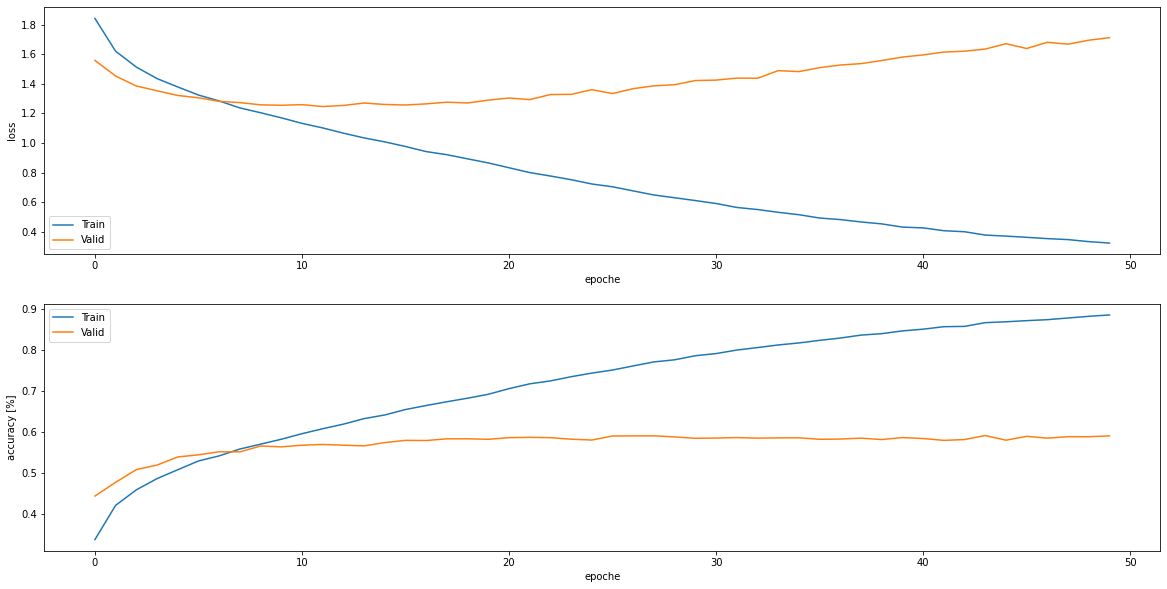

In [99]:
plt.figure(1, figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(train_losses)
plt.plot(valid_losses)
plt.xlabel("epoche")
plt.ylabel("loss")
plt.legend(["Train", "Valid"])

plt.subplot(2,1,2)
plt.plot(train_accuracies)
plt.plot(valid_accuracies)
plt.xlabel("epoche")
plt.ylabel("accuracy [%]")
plt.legend(["Train", "Valid"])

plt.show()

In [101]:
model = best_model[0]

with torch.no_grad():

    correct, total = 0, 0
    model.eval()

    for x, y in loader_test:

      x, y = x.to(device), y.to(device)
      logits = model(x)
      log_probs = F.log_softmax(logits, dim=1)
      loss = F.nll_loss(log_probs, y)

      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    
valid_accuracy = correct/total

print("The test accuracy: %s"%(valid_accuracy))
  

The test accuracy: 0.5792
